In [806]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import catboost as catb
import xgboost as xgb
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV

In [807]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

**1. Описание датасета**
* **Annual Income**- годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens**  - налоговые обременения               
* **Number of Open Accounts**  - количество открытых счетов   
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit**    - наибольший открытый кредит
* **Number of Credit Problems**    - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies**- банкротства
* **Purpose** - цель кредита
* **Term**- срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance**        - текущий кредитный баланс
* **Monthly Debt**       - ежемесячный долг
* **Credit Score**    -кредитный рейтинг из другого источника
* **Credit Default**  - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)


In [808]:
df_train = pd.read_csv('course_project_train.csv')
df_test =pd.read_csv('course_project_test.csv')

**2. Обработка пропусков**


In [809]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [810]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Исправим пункт "годовой доход"

In [811]:
df_train['Annual Income'].fillna(df_train['Annual Income'].mean(), inplace=True)

In [812]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,7.524812e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,9.311330e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.366392e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.499974e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Исправим пункт "количество лет на текущем месте работы"

In [813]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [814]:
#Переведем данный признак в числовой формат
Data_map = {
    "10+ years":10,
"2 years":2,
"3 years":3,
"< 1 year":0,
"5 years":5,
"1 year":1,
"4 years":4,
"6 years":6,
"7 years":7, 
"8 years":8,
"9 years":9
}
df_train["Years in current job"]=df_train["Years in current job"].map(Data_map)

In [815]:
df_train['Years in current job'].describe()

count    7129.000000
mean        5.880348
std         3.620092
min         0.000000
25%         3.000000
50%         6.000000
75%        10.000000
max        10.000000
Name: Years in current job, dtype: float64

In [816]:
df_train['Years in current job'].fillna(df_train['Years in current job'].median(), inplace=True)

In [817]:
df_train['Years in current job'].describe()

count    7500.000000
mean        5.886267
std         3.529503
min         0.000000
25%         3.000000
50%         6.000000
75%        10.000000
max        10.000000
Name: Years in current job, dtype: float64

Исправим пункт "количество месяцев с последней просрочки платежа"

In [818]:
df_train['Months since last delinquent'].fillna(0, inplace=True)

Проанализируем и исправим пункт "Банкротства"

In [819]:
df_train["Bankruptcies"].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [820]:
df_train["Bankruptcies"].fillna(0, inplace=True)

Исправим пункт "Credit Score"

In [821]:
df_train["Credit Score"].fillna(df_train["Credit Score"].mode(), inplace=True)

Проверяем на пропуски

In [822]:
df_train.isnull().sum()

Home Ownership                     0
Annual Income                      0
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

**3. Обработка Датасета**

In [823]:
df_train.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,5.886267,0.030133,11.130933,18.317467,9.451537e+05,0.170000,15.815200,0.116933,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,7.524812e+05,3.529503,0.271604,4.908924,7.041946,1.602622e+07,0.498598,22.649441,0.346904,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,9.311330e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,0.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.366392e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,29.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Переведем признак "Tax Liens" в категориальный формат

In [824]:
df_train["Tax Liens"].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [825]:
df_train.loc[df_train["Tax Liens"] >0, "Tax Liens"] = 1

In [826]:
df_train["Tax Liens"].value_counts()

0.0    7366
1.0     134
Name: Tax Liens, dtype: int64

Переведем признак "Home Ownership" в категориальный формат

In [827]:
df_train["Home Ownership"].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [828]:
df_train= pd.get_dummies(df_train,columns=["Home Ownership"])

Переведем признак "Purpose" в категориальный формат

In [829]:
df_train["Purpose"].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [830]:
df_train= pd.get_dummies(df_train,columns=["Purpose"])

Переведем признак "Term" в категориальный формат

In [831]:
df_train["Term"].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [832]:
df_train.loc[df_train["Term"]=="Long Term", "Term"] = 1
df_train.loc[df_train["Term"]=="Short Term", "Term"] = 0

In [833]:
df_train

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,4.820870e+05,6.0,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.025487e+06,10.0,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
2,7.514120e+05,8.0,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,8.050680e+05,6.0,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
4,7.762640e+05,8.0,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,4.021920e+05,0.0,0.0,3.0,8.5,107866.0,0.0,0.0,0.0,0,...,0,0,0,0,1,0,0,0,0,0
7496,1.533984e+06,1.0,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
7497,1.878910e+06,6.0,0.0,12.0,32.1,1778920.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
7498,1.366392e+06,6.0,0.0,21.0,26.5,1141250.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


**4. Отбор признаков**

In [834]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

In [835]:
df_train.dtypes

Annual Income                   float64
Years in current job            float64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
Home Ownership_Have Mortgage      uint8
Home Ownership_Home Mortgage      uint8
Home Ownership_Own Home           uint8
Home Ownership_Rent               uint8
Purpose_business loan             uint8
Purpose_buy a car                 uint8
Purpose_buy house                 uint8
Purpose_debt consolidation        uint8
Purpose_educational expenses      uint8
Purpose_home improvements         uint8


In [836]:
NUM_FEATURE_NAMES=df_train.select_dtypes(include =['float64', 'int64']).columns

**5.Приведение признаков,их нормализация и разделение**

Нормализация

In [837]:
scaler = StandardScaler()
df_norm = df_train.copy()
df_norm[BASE_FEATURE_NAMES] = scaler.fit_transform(df_norm[BASE_FEATURE_NAMES])
df_train = df_norm.copy()

Разбиение

In [838]:
X = df_train[BASE_FEATURE_NAMES]
y = df_train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

Балансировка целевой переменной

In [839]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

**6.Обучение модели**

In [840]:
fin_model = catb.CatBoostClassifier(silent=True, random_state=21, n_estimators=500, max_depth=5,l2_leaf_reg=15)
fin_model.fit(X_train, y_train)

y_train_pred = fin_model.predict(X_train)
y_test_pred = fin_model.predict(X_test)
y_test_pred_probs = fin_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.99      0.89      3771
           1       0.92      0.39      0.54      1479

    accuracy                           0.82      5250
   macro avg       0.86      0.69      0.71      5250
weighted avg       0.84      0.82      0.79      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      1616
           1       0.78      0.30      0.44       634

    accuracy                           0.78      2250
   macro avg       0.78      0.63      0.65      2250
weighted avg       0.78      0.78      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1563   53
1                443  191


**7. Проверка качества, борьба с переобучением, выбор важных признаков**

In [841]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=5,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21)

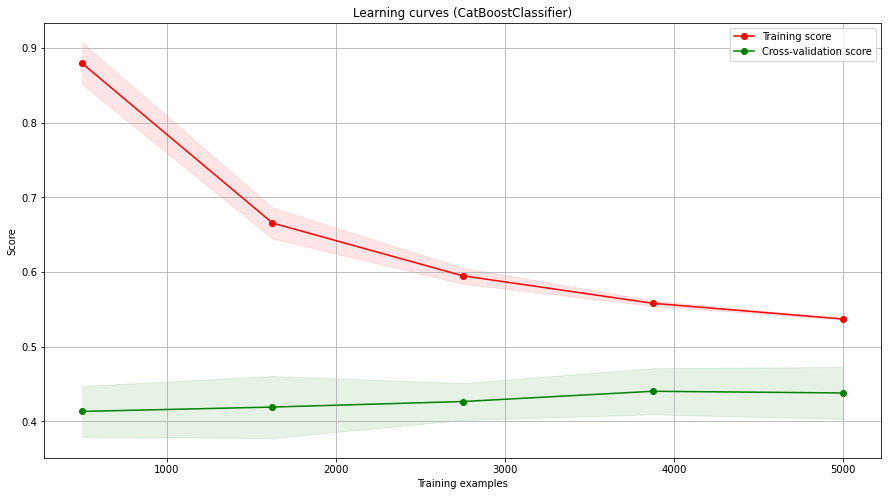

In [842]:
show_learning_curve_plot(fin_model, X, y)

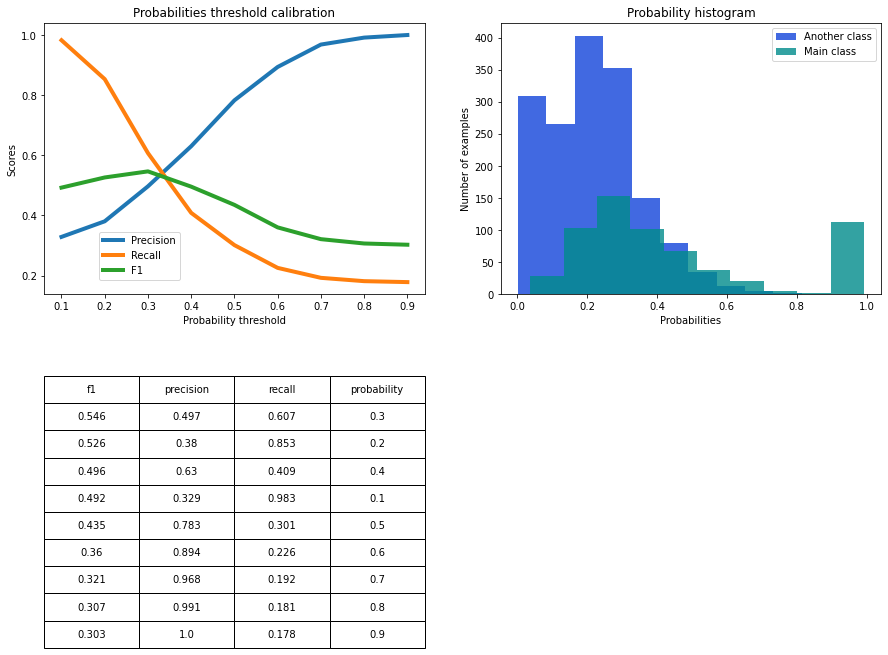

In [843]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

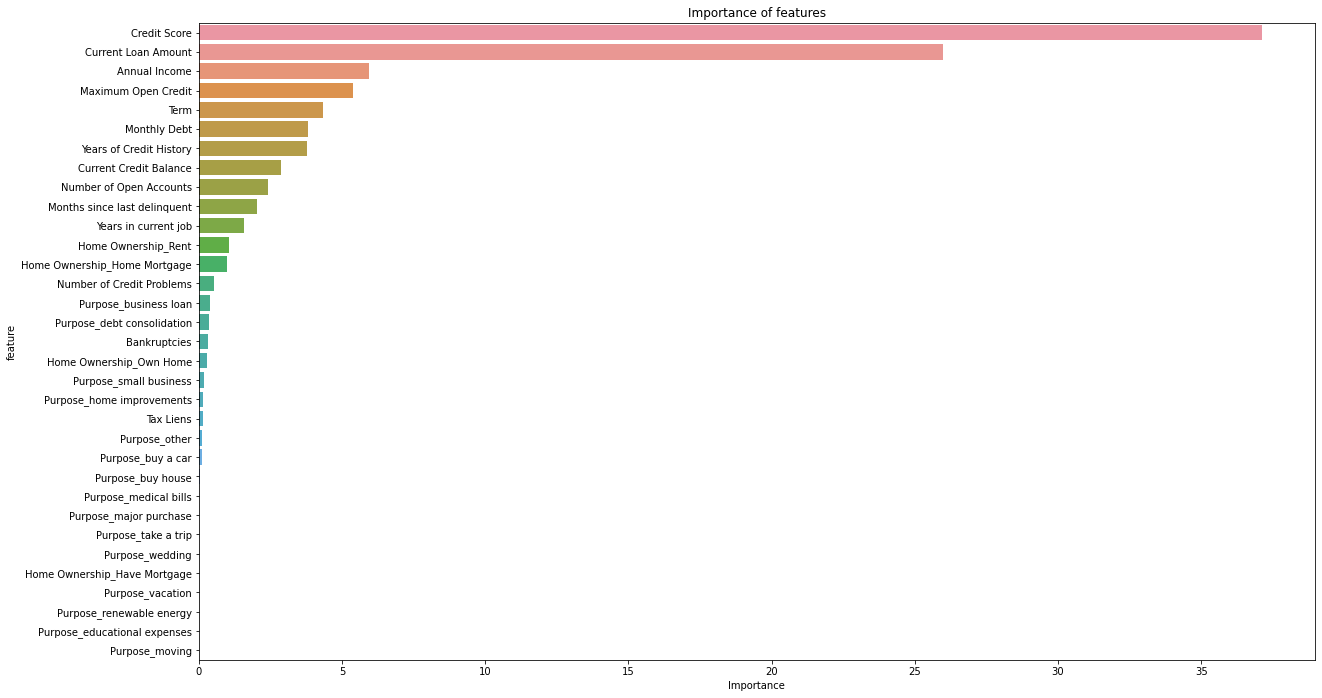

In [844]:
important_features_top = show_feature_importances(X_train.columns, fin_model.feature_importances_, get_top=11)

In [845]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Annual Income',
 'Maximum Open Credit',
 'Term',
 'Monthly Debt',
 'Years of Credit History',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Months since last delinquent',
 'Years in current job']

### Финальная модель

In [846]:
final_model = catb.CatBoostClassifier(class_weights=[1, 3.5], n_estimators=500, max_depth=5,l2_leaf_reg=20,
                                      silent=True, random_state=85)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.63      0.75      3771
           1       0.49      0.91      0.63      1479

    accuracy                           0.71      5250
   macro avg       0.72      0.77      0.69      5250
weighted avg       0.82      0.71      0.72      5250

TEST

              precision    recall  f1-score   support

           0       0.87      0.56      0.68      1616
           1       0.41      0.78      0.54       634

    accuracy                           0.62      2250
   macro avg       0.64      0.67      0.61      2250
weighted avg       0.74      0.62      0.64      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               908  708
1               137  497


Результат f1=0.54-считается допустимым

**Прогнозирование на тестовом датасете**

In [847]:
df_test['Annual Income'].fillna(df_test['Annual Income'].mean(), inplace=True)
df_test["Years in current job"]=df_test["Years in current job"].map(Data_map)
df_test['Years in current job'].fillna(df_test['Years in current job'].median(), inplace=True)
df_test['Months since last delinquent'].fillna(0, inplace=True)
df_test["Bankruptcies"].fillna(0, inplace=True)
df_test["Credit Score"].fillna(df_test["Credit Score"].mode(), inplace=True)
df_test.loc[df_train["Tax Liens"] >0, "Tax Liens"] = 1
df_test= pd.get_dummies(df_test,columns=["Home Ownership"])
df_test= pd.get_dummies(df_test,columns=["Purpose"])
df_test.loc[df_test["Term"]=="Long Term", "Term"] = 1
df_test.loc[df_test["Term"]=="Short Term", "Term"] = 0

In [848]:
scaler = StandardScaler()
df_test =scaler.fit_transform(df_test)

In [849]:
y_predd=final_model.predict(df_test)
y_predd

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

Экспортируем данные

In [855]:
itog=pd.DataFrame({"Id":[i for i in range(2500)],"Credit Default":y_predd})
itog.to_csv('Ryabko_predictions.csv ', index=False)

In [856]:
itog

,Id,Credit Default
0,0,0
1,1,1
2,2,1
3,3,0
4,4,0
...,...,...
2495,2495,0
2496,2496,0
2497,2497,0
2498,2498,0
